In [1]:
%load_ext autoreload
%autoreload 2

import torch
torch.__version__

'1.6.0'

In [2]:
import numpy as np
import torch
import random
import pickle
import sys
import os
import glob

sys.path.insert(0, '/home/jupyter/VLP/pythia')
sys.path.insert(0, '/home/jupyter/VLP/')

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForPreTrainingLossMask
from pytorch_pretrained_bert.optimization import BertAdam
from pathlib import Path
import pandas as pd
from vlp.loader_utils import batch_list_to_batch_tensors
import vlp.seq2seq_loader as seq2seq_loader
from vlp.seq2seq_loader import truncate_tokens_pair
import PIL
from vlp.lang_utils import language_eval

from fastai.vision.all import *


import pythia.tasks.processors as pythia_proc

from util import *

In [3]:
class ArgDummy(dict):
    def __getattr__(self, attr):
        return self[attr]
args = ArgDummy()
DATA_ROOT = '/mnt/ssd/data'
HATE_PATH = Path('/home/jupyter/mmf_data/datasets/hateful_memes/defaults/')
HATE_FEAT_PATH = Path('/home/jupyter/hateful_features/region_feat_gvd_wo_bgd')

args['bert_model'] = 'bert-base-cased' #Bert pre-trained model selected
args['seed'] = 123 #random seed for initialization
args['len_vis_input'] = 100
args['max_tgt_length'] = 20 #maximum length of target sequence
args['region_det_file_prefix'] = 'feat_cls_1000/coco_detection_vg_100dets_gvd_checkpoint_trainval'
args['output_dir'] ='tmp'
args['drop_prob'] = 0.1
args['model_recover_path'] = './checkpoints/vqa2_g2_lr2e-5_batch512_ft_from_s0.75_b0.25/model.19.bin'
args['image_root'] = f'{DATA_ROOT}/flickr30k/region_feat_gvd_wo_bgd/'
args['region_bbox_file'] =f'{DATA_ROOT}/flickr30k/region_feat_gvd_wo_bgd/flickr30k_detection_vg_thresh0.2_feat_gvd_checkpoint_trainvaltest.h5'
args['do_lower_case'] = True
args.region_bbox_file = os.path.join(args.image_root, args.region_bbox_file)
args.region_det_file_prefix = os.path.join(args.image_root, args.region_det_file_prefix)
args.max_seq_length = args.max_tgt_length + args.len_vis_input + 3 # +3 for 2x[SEP] and [CLS]

In [4]:
device = torch.device('cuda')
# fix random seed
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)
tokenizer.max_len = args.max_seq_length

In [5]:
class HateStem(torch.nn.Module):
    
    def __init__(self, vlp):
        super(HateStem, self).__init__()
        self.vis_embed = vlp.vis_embed #Linear->ReLU->Linear->ReLU->dropout
        self.vis_pe_embed = vlp.vis_pe_embed #Linear->ReLU->dropout
        self.bert = vlp.bert # pytorch_pretrained_bert.modeling.BertModel
        self.len_vis_input = vlp.len_vis_input
        
    
    def forward(self, vis_feats, vis_pe, input_ids, token_type_ids=None, attention_mask=None):
        vis_feats = self.vis_embed(vis_feats) # image region features
        vis_pe = self.vis_pe_embed(vis_pe) # image region positional encodings

        sequence_output, pooled_output = self.bert(vis_feats, vis_pe, input_ids, token_type_ids,
            attention_mask, output_all_encoded_layers=False, len_vis_input=self.len_vis_input)
        #print(sequence_output.shape, pooled_output.shape)
        vqa2_embed = sequence_output[:, 0]*sequence_output[:, self.len_vis_input+1]
        return vqa2_embed
        #return sequence_output


In [6]:
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, bn_final=False, lin_first=False, ):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    layers = [Flatten()]
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [7]:
class HateClassifier(torch.nn.Module):
     def __init__(self, stem):
        super(HateClassifier, self).__init__()
        self.stem = stem
        self.classifier = create_head(768,2, ps=.5)
     #def forward(self, id, vis_feats, vis_pe, input_ids, token_type_ids, attention_mask):  
     def forward(self, params):  
        id, vis_feats, vis_pe, input_ids, token_type_ids, attention_mask = params
        embs = self.stem(vis_feats, vis_pe, input_ids, token_type_ids, attention_mask)
        return self.classifier(embs)

In [8]:
def new_model():
    hate_stem = torch.load('checkpoints/vlp_stem.pth')
    
    return  HateClassifier(hate_stem).cuda()


In [9]:
path =  Path('/home/jupyter/VLP')
data =pd.read_csv(path/'captioned.csv')
data[:3]

,id,img,label,text,caption,is_valid,tex_cap
0,42953,img/42953.png,0.0,its their character not their color that matters,A man in a black shirt is looking at the camera .,False,A man in a black shirt is looking at the camera . <meme> its their character not their color that matters
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not like your ex,A man in a suit is talking to a woman in a white shirt .,False,A man in a suit is talking to a woman in a white shirt . <meme> don't be afraid to love again everyone is not like your ex
2,13894,img/13894.png,0.0,putting bows on your pet,A cat with a red bow tied around its neck sits next to a pillow .,False,A cat with a red bow tied around its neck sits next to a pillow . <meme> putting bows on your pet


In [10]:
class VLPID(TensorBase):pass

In [11]:
def load_from_row(row, proc, q=None):
    img_id = row.id
    text = row.text
    if q is None: q = text
    img_file = id_to_img_path(img_id)
    instance = (img_file, tokenizer.tokenize(q), {'answers': ['dummy']})
    input_ids, segment_ids, input_mask, conv_feats, vis_masked_pos, vis_pe= proc(instance)
    return VLPID(img_id), conv_feats, vis_pe, input_ids, segment_ids, input_mask

In [12]:
def id_to_text(id):
    return first(data[data.id==id].text)
def id_to_label(id):
    return first(data[data.id==id].label)
def id_to_img_path(id):
    id = f'{int(id):05d}'
    return str(HATE_PATH/f'images/img/{id}.png')
def id_to_features(id):
    id_suf = id[-2:]
    feat = HATE_FEAT_PATH/'feat_cls_1000'/f'hateful_vlp_checkpoint_trainval_feat{id_suf}.h5'
    clas = HATE_FEAT_PATH/'feat_cls_1000'/f'hateful_vlp_checkpoint_trainval_cls{id_suf}.h5'
    bbox = HATE_FEAT_PATH/'raw_bbox'/f'hateful_vlp_checkpoint_trainval_bbox{id_suf}.h5'
    return feat, clas, bbox

In [13]:
def load(idx, proc, q=None):
    return load_from_row(data.iloc[idx],proc, q)

In [14]:
from random import randint, shuffle, choices
from random import random as rand
import h5py
from vlp.loader_utils import get_random_word
class PreprocessVLP(Pipeline):
    """ Pre-processing steps for pretraining transformer """

    def __init__(self, max_pred, mask_prob, vocab_words, indexer, max_len=512, block_mask=False, truncate_config={}, mask_image_regions=False, mode="s2s", len_vis_input=49, vis_mask_prob=0.25, 
                  region_bbox_prefix='',  region_bbox_file = None, region_det_file_prefix='', local_rank=-1, load_vqa_ann=False, id_digits=3):
        super().__init__()
        self.max_pred = max_pred  # max tokens of prediction
        self.mask_prob = mask_prob  # masking probability
        self.vocab_words = vocab_words  # vocabulary (sub)words
        self.indexer = indexer  # function from token to token index
        self.max_len = max_len
        self._tril_matrix = torch.tril(torch.ones(
            (max_len, max_len), dtype=torch.long))
        self.always_truncate_tail = truncate_config.get(
            'always_truncate_tail', False)
        self.max_len_b = truncate_config.get('max_len_b', None)
        self.trunc_seg = truncate_config.get('trunc_seg', None)
        self.mask_image_regions = mask_image_regions
        assert mode in ("s2s", "bi")
        self.mode = mode
        self.region_bbox_prefix = region_bbox_prefix
        self.region_bbox_file = region_bbox_file
        self.region_det_file_prefix = region_det_file_prefix
        self.id_digits = id_digits


        self.len_vis_input = len_vis_input
        self.vis_mask_prob = vis_mask_prob

        # for images
        if load_vqa_ann:
            # import packages from pythia
            import pythia.tasks.processors as pythia_proc # VQAAnswerProcessor
            from pythia.utils.configuration import ConfigNode
            args = {'vocab_file': '/home/jupyter/VLP/pythia/data/vocabs/answers_vqa.txt', 'num_answers':10, 'preprocessor':{'type':'simple_word', 'params':{}}}
            args = ConfigNode(args)
            self.ans_proc = pythia_proc.registry.get_processor_class('vqa_answer')(args)
        else:
            self.ans_proc = None


    def __call__(self, instance):
        img_path, tokens_b = instance[:2]
        tokens_a = ['[UNK]'] * self.len_vis_input

        truncate_tokens_pair(tokens_a, tokens_b,
            self.len_vis_input + self.max_len_b, max_len_b=self.max_len_b,
            trunc_seg=self.trunc_seg, always_truncate_tail=self.always_truncate_tail)

        # Add Special Tokens
        tokens = ['[CLS]'] + tokens_a + ['[SEP]'] + tokens_b + ['[SEP]']

        segment_ids = [0] * (len(tokens_a)+2) + [1] * (len(tokens_b)+1)
       

        # For masked Language Models
        # the number of prediction is sometimes less than max_pred when sequence is short
        effective_length = len(tokens_b)
        n_pred = min(self.max_pred, max(
            1, int(round(effective_length * self.mask_prob))))
        # candidate positions of masked tokens
        cand_pos = []
        special_pos = set()
        for i, tk in enumerate(tokens):
            # only mask tokens_b (target sequence)
            # we will mask [SEP] as an ending symbol
            if (i >= len(tokens_a)+2) and (tk != '[CLS]'):
                cand_pos.append(i)
            else:
                special_pos.add(i)
        shuffle(cand_pos)

        masked_pos = cand_pos[:n_pred]
        if self.mask_image_regions:
            vis_masked_pos = np.random.choice(self.len_vis_input,
                int(self.len_vis_input*self.vis_mask_prob), replace=False)+1 # +1 for [CLS], always of the same length, no need to pad
        else:
            vis_masked_pos = []

        masked_tokens = [tokens[pos] for pos in masked_pos]
        for pos in masked_pos:
            if rand() < 0.8:  # 80%
                tokens[pos] = '[MASK]'
            elif rand() < 0.5:  # 10%
                tokens[pos] = get_random_word(self.vocab_words)
        # Token Indexing
        input_ids = self.indexer(tokens)

        # Zero Padding
        n_pad = self.max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        segment_ids = torch.tensor(segment_ids, dtype=torch.long)
        # self-attention mask
        input_mask = torch.zeros(self.max_len, self.max_len, dtype=torch.long)
        second_st, second_end = len(tokens_a)+2, len(tokens_a)+len(tokens_b)+3

        if self.mode == "s2s":
            input_mask[:, :len(tokens_a)+2].fill_(1)
            input_mask[second_st:second_end, second_st:second_end].copy_(
                self._tril_matrix[:second_end-second_st, :second_end-second_st])
        else:
            input_mask = torch.tensor([1] * len(tokens) + [0] * n_pad, dtype=torch.long) \
                .unsqueeze(0).expand(self.max_len, self.max_len).clone()

        if self.mask_image_regions:
            input_mask[:, vis_masked_pos].fill_(0) # block the masked visual feature

        # Zero Padding for masked target
        if self.max_pred > n_pred:
            n_pad = self.max_pred - n_pred
            masked_pos.extend([0] * n_pad)


        # loading pre-processed features
        img_id = img_path.split('/')[-1].split('.')[0]
        if self.region_bbox_file is not None:
            bbox_file = self.region_bbox_file
        else:
            bbox_file = self.region_bbox_prefix+'_bbox'+img_id[-self.id_digits:]+'.h5'
        if self.region_det_file_prefix != '':
            # read data from h5 files
            with h5py.File(self.region_det_file_prefix+'_feat'+img_id[-self.id_digits:] +'.h5', 'r') as region_feat_f, \
                    h5py.File(self.region_det_file_prefix+'_cls'+img_id[-self.id_digits:] +'.h5', 'r') as region_cls_f, \
                    h5py.File(bbox_file, 'r') as region_bbox_f:
                img = torch.from_numpy(region_feat_f[img_id][:]).float()
                cls_label = torch.from_numpy(region_cls_f[img_id][:]).float()
                vis_pe = torch.from_numpy(region_bbox_f[img_id][:])
        else:
            # legacy, for some datasets, read data from numpy files
            img = torch.from_numpy(np.load(img_path))
            cls_label = torch.from_numpy(np.load(img_path.replace('.npy', '_cls_prob.npy')))
            with h5py.File(self.region_bbox_file, 'r') as region_bbox_f:
                vis_pe = torch.from_numpy(region_bbox_f[img_id][:])

        # lazy normalization of the coordinates...
        w_est = torch.max(vis_pe[:, [0, 2]])*1.+1e-5
        h_est = torch.max(vis_pe[:, [1, 3]])*1.+1e-5
        vis_pe[:, [0, 2]] /= w_est
        vis_pe[:, [1, 3]] /= h_est
        assert h_est > 0, 'should greater than 0! {}'.format(h_est)
        assert w_est > 0, 'should greater than 0! {}'.format(w_est)
        rel_area = (vis_pe[:, 3]-vis_pe[:, 1])*(vis_pe[:, 2]-vis_pe[:, 0])
        rel_area.clamp_(0)

        vis_pe = torch.cat((vis_pe[:, :4], rel_area.view(-1, 1), vis_pe[:, 5:]), -1) # confident score
        normalized_coord = F.normalize(vis_pe.data[:, :5]-0.5, dim=-1)
        vis_pe = torch.cat((F.layer_norm(vis_pe, [6]), \
            F.layer_norm(cls_label, [1601])), dim=-1) # 1601 hard coded...

        
        return (input_ids, segment_ids, input_mask, img, vis_masked_pos, vis_pe)



In [15]:
region_pref = HATE_FEAT_PATH / 'feat_cls_1000/hateful_vlp_checkpoint_trainval'
bbox_pref = HATE_FEAT_PATH / 'raw_bbox/hateful_vlp_checkpoint_trainval'
id_digits=2

truncate_config={
    'max_len_b': args.max_tgt_length, 'trunc_seg': 'b', 'always_truncate_tail': True}

max_masked = 10
mask_prob = .2
mask_img=True
vis_mask_prob = 0.2
train_proc = PreprocessVLP(max_masked, mask_prob,
    list(tokenizer.vocab.keys()), tokenizer.convert_tokens_to_ids, args.max_seq_length,
    truncate_config=truncate_config,mask_image_regions=mask_img, vis_mask_prob=vis_mask_prob,
    mode="bi", len_vis_input=args.len_vis_input, 
    region_bbox_prefix=str(bbox_pref), region_det_file_prefix=str(region_pref), id_digits=id_digits,
    load_vqa_ann=True)

val_proc = PreprocessVLP(0, 0,
    list(tokenizer.vocab.keys()), tokenizer.convert_tokens_to_ids, args.max_seq_length,
    truncate_config=truncate_config,mask_image_regions=mask_img, vis_mask_prob=vis_mask_prob,
    mode="bi", len_vis_input=args.len_vis_input, 
    region_bbox_prefix=str(bbox_pref), region_det_file_prefix=str(region_pref), id_digits=id_digits,
    load_vqa_ann=True)

In [16]:


def get_y(row):
    return int(row['label'])

class LoadRow(Transform):
   
    def __init__(self, split_idx, processor):
        self.split_idx = split_idx
        self.proc = processor
    
    def encodes(self, x, **kwargs):
        #print(self.proc.mask_prob)
        return load_from_row(x, self.proc)

In [17]:
db = DataBlock(get_x = Pipeline([LoadRow(0, train_proc),LoadRow(1, val_proc)]), get_y=get_y,  splitter=ColSplitter('is_valid'))
dls = db.dataloaders(data[:9000],bs=32, device=device, decode = lambda x:34)


len(dls.train_ds), len(dls.valid_ds)


(8500, 500)

In [18]:
@typedispatch
def show_batch(x:tuple, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ids = x[0]
    for i,ctx in enumerate(ctxs):
        show(ids[i], ctx)
    return ctxs

def show(id, ctx, **kwargs):
        id = id.item()
        tit = str(id_to_label(id)) + ': ' + id_to_text(id)
        show_title(tit[:20], ctx =ctx)
        show_image(PILImage.create(id_to_img_path(id)), ctx=ctx)


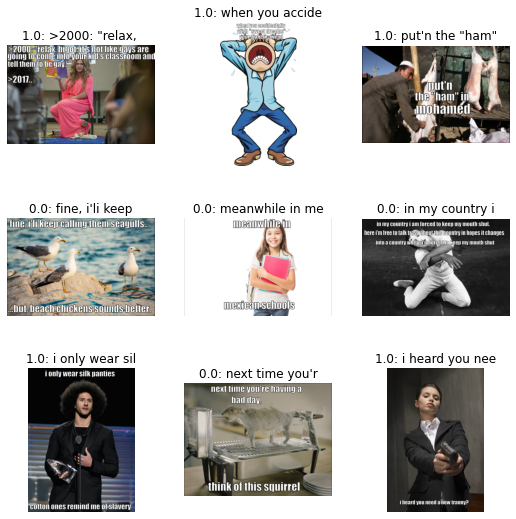

In [19]:
dls.show_batch(dls.one_batch(), 9)

In [20]:
def vlp_splitter(model):
    return L(params(model.stem.vis_embed) + params(model.stem.vis_pe_embed), 
            params(model.stem.bert),
            params(model.classifier))

In [21]:
model = new_model()
learn = Learner(dls, model,nn.CrossEntropyLoss(),metrics=[accuracy, RocAucBinary()], splitter=vlp_splitter)

In [22]:
learn.fit_one_cycle(8, lr_max=5e-5)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.768120,0.739181,0.594000,0.596272,02:01
1,0.698455,0.897294,0.524000,0.621904,02:01
2,0.705322,0.773773,0.560000,0.648448,02:01
3,0.581509,0.694525,0.584000,0.659872,02:01
4,0.484652,0.675582,0.632000,0.708560,02:01
5,0.356022,0.793184,0.638000,0.727408,02:01
6,0.242927,0.919320,0.638000,0.734368,02:01
7,0.192642,1.013276,0.642000,0.740672,02:01


In [23]:
learn.save('attempt14')

Path('models/attempt14.pth')

In [24]:
gen_submit(learn, 'attempts/attempt14.csv', True)

/home/jupyter/dl_experiments/Hateful/util.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(preds)


In [126]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

TypeError: object of type 'VLPBatch' has no len()

In [ ]:
#gen_submit(learn, 'attempts/attempt12.csv', True)